# Exploring NC NO2 hourly emmisions

**Data Source:** [EPA pregenerated hourly data files](https://aqs.epa.gov/aqsweb/airdata/download_files.html#Raw)

**I'm using hourly data so we can explore the data at many different time scales, and in doing so, learn how to do aggregations at many scales on dates and times.**

The EPA has hourly data for Ozone, SO2, CO, and NO2 for all sites in the US. Because that data is quite large, I have filtered down to only North Carolina sites, and I excluded Lee County because that data was incomplete for 2018. I have also filtered down to a subset of the columns, leaving only the State, County, Site, Date, Time and Measured value.

Here is an example of the output if you load in one row from the original data. (Note that not all columns are visible in this output...)

<img src="images/EPA_data_head.png" />

---

*To preserve the mystery, select from the notebook menus*

`Edit -> Clear All Outputs`

---

## Load NC subset for exploration


In [1]:
import pandas as pd

### Be careful of data types

- **Since the "Site Num" values look like integers but have leading zeros, you need to force Pandas to interpret that column as strings!**
- **We're combining the date and time and parsing them as a datetime object during the CSV read!**

NOTE: Because the State Name, County Name, and Site Num values are repeated many many times throughout the data set, this would be a great opportunity to tell Pandas to interpret them as **"category" data type**. This would save space in memory and make some computations faster, but introduces a complication in the GroupBy functionality since not all categorical combinations appear in the data set. (e.g. not all counties have all site numbers, so when you do the groupby() you need to include `observed=True` as an argument) See the [Groupby_NCcategorical](Groupby_NCcategorical.ipynb) notebook for coverage of those issues.

#### In a single, chained command, we're

- reading the CSV file
- combining the date + time columns and parsing them as a datetime object and naming that column
- forcing the site number to be parsed as a string
- renaming four of the columns
- setting the time stamp datetime column "tstamp" as the DataFrame index

In [2]:
df = pd.read_csv(
    "./data/AirDataEPA/NC_NO2_hourly_2018.csv",
    parse_dates = {"tstamp":["Date Local", "Time Local"]},
    dtype = {'Site Num':'str'}
).rename(
    columns = {
        "State Name": "state",
        "County Name": "county",
        "Site Num": "site",
        "Sample Measurement": "measure"
    }
).set_index('tstamp')

In [3]:
df.head()

,site,measure,state,county
tstamp,,,,
2018-01-01 00:00:00,0022,4.4,North Carolina,Forsyth
2018-01-01 01:00:00,0022,5.1,North Carolina,Forsyth
2018-01-01 02:00:00,0022,3.6,North Carolina,Forsyth
2018-01-01 03:00:00,0022,4.1,North Carolina,Forsyth
2018-01-01 04:00:00,0022,4.6,North Carolina,Forsyth


## Too much data to see patterns without aggregation

Even in this reduced data set, for a single year there are almost 40k rows!

In [4]:
df.shape

(39205, 4)

---

# GroupBy

## Mean emissions by county

**To start exploring the data and seeing trends or patterns, we need to make comparisons between different counties, sites, dates and times.**

We can see the same sort of behavior as in our basic example when grouping by a single categorical variable. Mecklenburg County has the highest mean emissions over the whole year for all sites in that county.

In [5]:
df.groupby('county').agg({'measure':'mean'})

,measure
county,
Forsyth,6.652983
Mecklenburg,8.361926
Wake,6.834003


## GroupBy County and Site creates a multi-index

When we group by multiple categorical variables and see that Pandas creates a multi-index. Now we can see that two of the counties have two sites, and their mean emissions vary quite a bit, with the one of the Wake County sites having higher mean emissions than the lower of the two Mecklenburg sites.

In [6]:
county_site_df = df.groupby(['county','site']).agg({'measure':'mean'})
county_site_df

measure
county      site           
Forsyth     0022   6.652983
Mecklenburg 0041   6.282450
            0045  10.198556
Wake        0014   4.955026
            0021   8.700441

### Use tuples for multi-index access

To select values from a multi-index, combine the values in a tuple. **Order matters!**

In [7]:
county_site_df.loc[('Wake','0021'),:]

measure    8.700441
Name: (Wake, 0021), dtype: float64

### Partial hierarchy return

Including only the highest level value in a multi-index returns all sub-values

In [8]:
county_site_df.loc[('Wake'),:]

,measure
site,
0014,4.955026
0021,8.700441


### Can get multi-index in both rows and columns

MultiIndex is a bit of a pain, but that's what you get both in rows and columns when you either do multiple groupby levels or multiple aggregation functions 

In [9]:
df.groupby(['county','site']).agg({'measure':['min','mean','max']})

measure                 
                     min       mean   max
county      site                         
Forsyth     0022     0.4   6.652983  41.0
Mecklenburg 0041     0.3   6.282450  39.6
            0045     0.3  10.198556  39.2
Wake        0014     0.3   4.955026  38.2
            0021     0.1   8.700441  35.0

### Sort results to see rank order

Sorting values using `.sort_values()` can be a big help in exploration – it gives you a ranking in that measure – but **remember to select the sorting column(s) using the tuple notation in a multi-index situation.**

In [10]:
df.groupby(['county','site']).agg(
    {'measure':['min','mean','max']}
).sort_values(
    [('measure','mean')],
    ascending=False
)

measure                 
                     min       mean   max
county      site                         
Mecklenburg 0045     0.3  10.198556  39.2
Wake        0021     0.1   8.700441  35.0
Forsyth     0022     0.4   6.652983  41.0
Mecklenburg 0041     0.3   6.282450  39.6
Wake        0014     0.3   4.955026  38.2

---

# Pivot table to explore the data

GroupBy is important for creating tidy data that is ready for further analysis, but sometimes you want to compare across groups visually in a table. In those cases it's easiest to see the patterns in a pivot table, which is a "wide" format, vs the "tall" format of tidy data. We will also use pivot tables to prepare data for visualization using the Pandas built-in plotting functions.

*Note: This is similar to what you would do in Excel – take event data and aggregate by creating a pivot table, and then either view those directly, or create charts from the pivot table.*

## Pivot table syntax

Pandas pivot_table() documentation: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html

`pandas.pivot_table(data, values=None, index=None, columns=None, aggfunc='mean', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False)`

- **index**: the variable(s) that will become the index (row labels)
- **columns**: the variable(s) that will become the column(s) (column labels)
- **values**: the column that will be aggregated and become the body of the table
- **aggfunc**: the aggregation function that will be used – same as in groupby(). A list will generate multiple tables "side-by-side" in the "columns" direction.


## Exploring time trends with pivot_table()

Since our DataFrame index is a datetime, we can use special built-in Pandas date and time functionailty.

### DatetimeIndex Attributes

The DatetimeIndex class has a lot of optimized features, which are detailed in [the Index section of the Time series / date functionality documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#indexing)

In Tableau there is the concept of **discreet date parts**, which we use when we want to extract part of a date or time, and ignore the rest of the information. For example:

- **Is there a trend in our data through the days of the week?** *Maybe more emissions happen on weekdays, and less on weekends?* In that case we want to know what happens on Sundays, Mondays, etc, but ignore what month or year or hour the data comes from and aggregate over all of those attributes while preserving the weekday categorical distinction.
- **Is there a seasonal trend over the months of the year?** *Maybe there are more emissions during the winter or summer?* In this case all we want to retain is whether the data is from a January, or a February, etc, and ignore (i.e. aggregate over) all other attributes like what hour or day or year they're from.
- **Is there a trend across hours in the day?** *Maybe there are more emissions when more people are awake, or sleeping?* In this case we want to know which of the 24 hours during a day something occurred in, and aggregate across everything else.

[Datetime index attributes](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html) – gives you categorical date/time parts like month, day, minute, etc

*Note: One thing I find quite inconvenient is that the date and time attributes turn into integers (starting at 0 or 1, depending on the specifics) instead of staying nice, human-readable values. (e.g. February == 2, Monday == 0, etc.) DatetimeIndex has some methods like `.month_name()`, but by default the pivot tables will be sorted alphabetically rather than in calendar month order...*

### Resampling

If you want to preserve a sense of continuous time, but aggregate up to a coarser time level than the original data date/time sampling level of detail, there is a concept in Pandas of **resampling** date and time data. Resampling is "a time-based groupby, followed by a reduction method on each of its groups." For example, if you have hourly data and want to convert that data (through aggregation like a mean or sum) into daily or monthly or yearly data, you need to resample.

This can be done in conjunction with a groupby() operation. I give one example of this at the very end of this lesson.

- Resample in timeseries documentation: [Date/Time resampling](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#resampling)
- Series.resample() documentation: [Resample method](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.resample.html)
- Valid strings for resampling frequency: [date-offset object docs](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects)

## Number of records from each site over months of the year

To see how complete our data is, we want to display the count of records over the 12 months of the year for each site. (The grouping over state that I do below is not necessary at all here.) To do this we'll create a pivot table where 

- the rows look like a groupby() combination of state, county and site
- the columns are the extracted discreet datetime "month" part
- the values populating the main part of the table are a "count" of the "measure" values

**Some of the counties and sites are more complete than others.** For reference:

- 28 days * 24 hours == 672 samples
- 31 days * 24 hours == 744 samples

In [11]:
df.pivot_table(
    index=['state','county','site'],
    columns=df.index.month_name(),
    values='measure',
    aggfunc='count'
)

tstamp                           April  August  December  February  January  \
state          county      site                                               
North Carolina Forsyth     0022  686.0   691.0     703.0     631.0    704.0   
               Mecklenburg 0041  687.0   704.0       NaN     644.0    714.0   
                           0045  683.0   713.0     689.0     635.0    706.0   
               Wake        0014  678.0   673.0     704.0     509.0    705.0   
                           0021  677.0   690.0     597.0     634.0    696.0   

tstamp                            July   June  March    May  November  \
state          county      site                                         
North Carolina Forsyth     0022  706.0  676.0  701.0  697.0     669.0   
               Mecklenburg 0041  714.0  677.0  697.0  705.0     467.0   
                           0045  667.0  690.0  712.0  703.0     614.0   
               Wake        0014  692.0  681.0  699.0  692.0     683.0   
                           0021  701.0  681.0  696.0  698.0     683.0   

tstamp                           October  September  
state          county      site                      
North Carolina Forsyth     0022    702.0      682.0  
               Mecklenburg 0041    560.0      525.0  
                           0045    690.0      530.0  
               Wake        0014    636.0      537.0  
                           0021    652.0      537.0

---

## Output styling

It's hard for people to see patterns in large groups of numbers, and sometimes extra visual elements like the ".0" at the end of all of those counts, make it even harder.

**Pandas has a concept of output styling for pivot tables, similar to Excel's "Conditional Formatting"**

https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html


### Set number precision

In [12]:
df.pivot_table(
    index=['state','county','site'],
    columns=df.index.month,
    values='measure',
    aggfunc='count'
).style.set_precision(0)

### Background gradient (heatmap) – Higher mean emissions in the winter months

- Color scale is by default column-wise. You can change the axis to 1 for row-wise scaling
- The only way to get a common scale across the whole pivot table is to explicitly set `vmin=` and `vmax=`
- You can set a fractional threshold for dark to light text transition with `text_color_threshold`

#### Scaling color independently across rows:

*Let's us compare across months, but distorts the comparison between sites!*

In [13]:
df.pivot_table(
    index=['county','site'],
    columns=df.index.month,
    values='measure',
    aggfunc='mean'
).style.set_precision(1).background_gradient(axis=1).highlight_null('lightgray')

#### Common color scale across whole table

*Lets us in an undistorted way compare not only across months, but across sites.*

In [14]:
df.pivot_table(
    index=['county','site'],
    columns=df.index.month,
    values='measure',
    aggfunc='mean'
).style.set_precision(1).background_gradient(vmin=3, vmax=15).highlight_null('lightgray')

---

**To try the exercise below, select this cell and from the Jupyter menus choose**

`Run -> Run All Above Selected Cell`

## EXERCISE

**Explore with a heatmap-styled pivot table, how mean emissions at each site vary by hour of the day**

*Note: Type instead of using copy/paste for better retention*

Expected output:

<img src='images/Emissions_heatmap_hourofday.png' />

---

### Horizontal Bar styling

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.io.formats.style.Styler.bar.html

- **Make sure bars go to zero with `vmin=0` so you don't distort perception of the data! That's not the default!**
- **Also explicily set `vmax` to get a common maximum bar length across all columns!**

#### Higher median in the winter

In [15]:
df.pivot_table(
    columns=['county','site'],
    index=df.index.month,
    values='measure',
    aggfunc='median'
).style.set_precision(2).bar(vmin=0, vmax=16, color='#988675', width=90)

---

# Time series plots like Excel

The pivot tables themselves provide a visualization of the data, but **a line plot is a very natural visualization style for a time series.**

To use the built-in plotting functions of Pandas for data like this, just like in Excel we need to be careful which data goes in which direction in the pivot table.

- **Intended X-axis needs to be on the row index** – so, we need time to be going down the row index if we want time to be horizontal, from left to right, in our line plot
- **Separate lines will be made from each column** – so we want our counties and sites to be our columns

This happens to be the same arrangement we made for our horizontal bars styling above.

#### Pandas line plot

- General plot: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html
- Line plot: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.line.html

#### Higher hourly variance in winter months

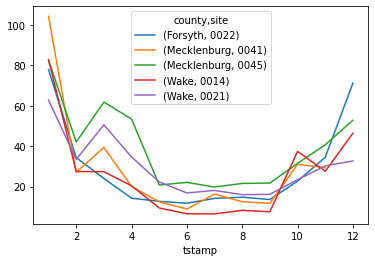

In [16]:
df.pivot_table(
    columns=['county','site'],
    index=df.index.month,
    values='measure',
    aggfunc='var'
).plot()

#### Emissions are lower on the weekends

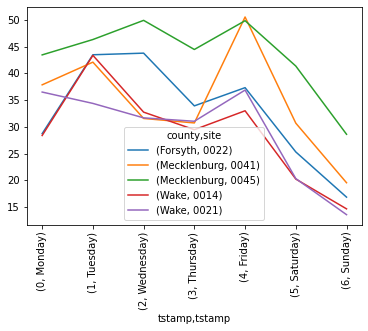

In [17]:
df.pivot_table(
    columns=['county','site'],
    index=[df.index.dayofweek,df.index.day_name()],
    values='measure',
    aggfunc='var'
).plot(rot=90)

---

**To try the exercise below, select this cell and from the Jupyter menus choose**

`Run -> Run All Above Selected Cell`

## EXERCISE

**Produce a line plot of mean emissions by hour of day, with a line for each site**

*Note: Type instead of using copy/paste for better retention*

Expected output:

<img src='images/LinePlot_hourofday.png' />

---

## Select certain columns to plot & figure size

- You can use the `y=` argument to select certain columns to plot
- and the figure size with `figsize=`

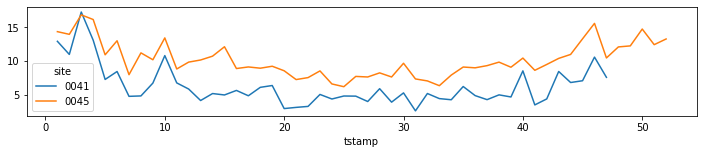

In [18]:
df.pivot_table(
    columns=['county','site'],
    index=df.index.week,
    values='measure',
    aggfunc='mean'
).plot(y=('Mecklenburg'),figsize=(12,2))

### Subplots for one line per plot

- Use the `subplots=True` argument to make small multiples if the plots overlap too much
- The `figsize` is for the combination of all subplots (not the size of each individual)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fcf102427c0>,
      dtype=object)

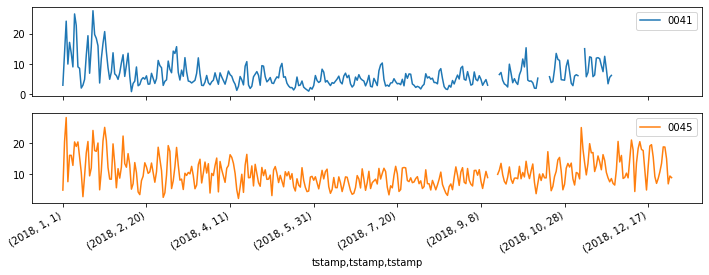

In [19]:
df.pivot_table(
    columns=['county','site'],
    index=[df.index.year, df.index.month, df.index.day],
    values='measure',
    aggfunc='mean'
).plot(y=('Mecklenburg'),figsize=(12,4),subplots=True)

---

**To try the exercise below, select this cell and from the Jupyter menus choose**

`Run -> Run All Above Selected Cell`

## EXERCISE

**Produce subplots, one for each county and site, showing the fully-detailed hourly data**

*Note: Type instead of using copy/paste for better retention*

Expected output:

<img src='images/LineSubPlots_hourly.png' />

---

# Plotting tidy data right out of groupby()

I like Altair, Seaborn, and Plotly for plotting in Python because they want tidy data that I can get right from a `groupby()` result without having to create a pivot table. That way I don't have to worry about which axis is which in my Pandas DataFrame – I can assign any variable to either plot axis.

- No need to create a pivot table – work directly with groupby()
- Capabilities for creating faceted plots
- Seaborn is better for built-in complicated statistical plots, but has hard-to-remember names for the plotting functions
- Altair has a more consistent interface for all types of plots, and it has built-in aggregation, including time-series, but for large data it works out better to filter and group first rather than letting Altair do the work
- Plotly has nice interaction built in, but Jupyter extension requires setup

**Note: You almost always have to run .reset_index() on the grouped, agregated DataFrame before you can plot with these modules.**

### Daily mean data

Here we are going to use `df.index.dayofyear` to aggregate to the daily level. You can see other options at:

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html

In [20]:
grp_dayofyear = df.groupby(['site',df.index.dayofyear]).agg({'measure':'mean'})
grp_dayofyear.head()

measure
site tstamp           
0014 1        2.665217
     2       11.204348
     3       12.730435
     4        2.660870
     5        5.726087

## Faceted line plot with Seaborn

`relplot()` is the Seaborn "Figure-level interface for drawing relational plots onto a FacetGrid"

- https://seaborn.pydata.org/examples/faceted_lineplot.html
- https://seaborn.pydata.org/generated/seaborn.relplot.html

*If you don't specify a categorical color palette, Seaborn will look at the values in "site" and re-interpret them as integers, then use a sequential (numerical) palette!!*

- https://seaborn.pydata.org/generated/seaborn.color_palette.html

**You need to use `.reset_index()` to access the index column(s) to plot.**

In [21]:
import seaborn as sns

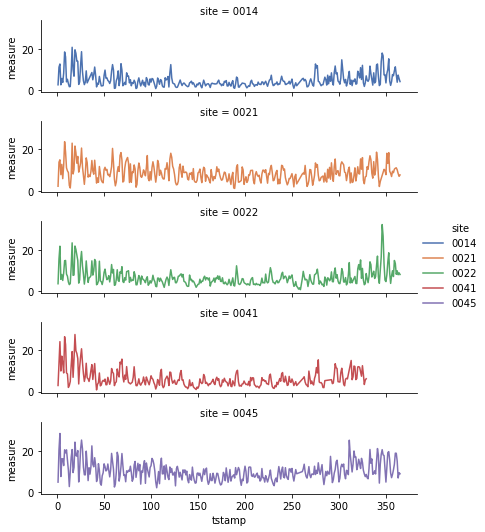

In [22]:
sns.relplot(
    data=grp_dayofyear.reset_index(), 
    x='tstamp', 
    y='measure', 
    hue='site',
    palette='deep',
    row='site',
    kind='line',
    aspect=4.0,
    height=1.5
)

---

## Altair for data visualization

Altair is a very nice alternative module for visualizing data that's in tidy form, right out of the aggregated groupby results. Another nice feature is that Altair has a lot of built-in aggregation itself, so you have extra options for date/time funcitons and nice display.

You can see examples of this in the 
[Groupby_NCcategorical](Groupby_NCcategorical.ipynb) 
notebook. More in-depth instruction can be found in 
[the video of my Altair workshop](https://library.capture.duke.edu/Panopto/Pages/Viewer.aspx?id=df15cf8e-86e1-4c6f-ac16-aab600f06c48) 
and the 
[accompanying GitHub repository](https://github.com/emonson/altair-vis-python)

*Example Altair output:*

<img src='images/Altair_monthdaysite.svg' />

---

# Resample for continuous time plots

Here's an example of resampling to the month start `('MS')` level in time while aggregating with both the mean and minimum.

- Valid strings for resampling frequency: [date-offset object docs](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects)

Because the groupby object still contains the same rows as the original, with the same index, you can apply `.resample()` after the `.groupby()`, which resamples within each group before the aggregation operations.

In [23]:
df.groupby(['county','site']).resample('MS').agg({'measure':['mean','min']}).head(20)

measure     
                                  mean  min
county      site tstamp                    
Forsyth     0022 2018-01-01  10.902699  1.0
                 2018-02-01   7.871474  1.2
                 2018-03-01   6.535093  1.2
                 2018-04-01   4.920262  0.5
                 2018-05-01   5.289096  0.9
                 2018-06-01   5.273817  1.1
                 2018-07-01   4.588669  1.1
                 2018-08-01   5.444139  1.2
                 2018-09-01   4.699853  0.4
                 2018-10-01   6.278775  1.0
                 2018-11-01   7.186697  1.3
                 2018-12-01  10.812233  1.4
Mecklenburg 0041 2018-01-01  13.098319  0.5
                 2018-02-01   6.308696  0.5
                 2018-03-01   6.706456  0.9
                 2018-04-01   5.268268  0.3
                 2018-05-01   4.110922  0.7
                 2018-06-01   4.808567  1.1
                 2018-07-01   4.535994  0.4
                 2018-08-01   4.657102  0.6

### Plotting still requires a pivot table

The only way I know how to arrange the data for Pandas-style plotting is to 

- do the `.groupby()`
- do the `.resample()` on the groups – here at the day `('D')` level
- `.reset_index()` to get the data ready for a pivot_table
- create the `.pivot_table()` like above
- `.plot()`

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fcf00e50a60>,
      dtype=object)

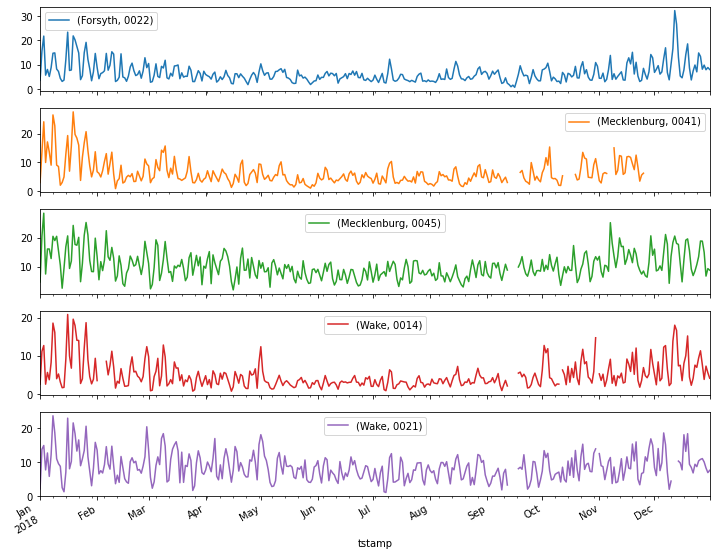

In [24]:
df.groupby(
    ['county','site']
).resample('D').agg({'measure':'mean'}).reset_index().pivot_table(
    columns=['county','site'],
    index='tstamp',
    values='measure'
).plot(subplots=True, figsize=(12,10))